In [1]:
import pandas as pd
import seaborn as sns 
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.stats import sem
%matplotlib inline
%config Completer.use_jedi = False


#import required sklearn for random forest classifier

import sklearn as sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix,roc_auc_score, f1_score, make_scorer
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold, RepeatedKFold, cross_validate
from sklearn.feature_selection import mutual_info_classif,VarianceThreshold, SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [2]:
#Import FPKM data for all cancers matched with tissue / cancer status

all_cancers_file = '/Users/jake/OneDrive - University of Glasgow/Project/Cancer Stratification/all_cancers_SS_filtered.csv'
all_cancers = pd.read_csv(all_cancers_file,header=[0,1],sep='\t',index_col=[0])

In [3]:
#Load all cis_95 95 csvs for all cancer types 

BRCA_cis_95_file = '/Users/jake/OneDrive - University of Glasgow/Project/BRCA/eQTL/eQTL_95/BRCA_cis_eQTL_95_ensembl.csv'
KIRC_cis_95_file = '/Users/jake/OneDrive - University of Glasgow/Project/KIRC/eQTL/eQTL_95/KIRC_cis_eQTL_95_ensembl.csv'
LUAD_cis_95_file = '/Users/jake/OneDrive - University of Glasgow/Project/LUAD/eQTL/eQTL_95/LUAD_cis_eQTL_95_ensembl.csv'
THCA_cis_95_file = '/Users/jake/OneDrive - University of Glasgow/Project/THCA/eQTL/eQTL_95/THCA_cis_eQTL_95_ensembl.csv'

BRCA_cis_95 = pd.read_csv(BRCA_cis_95_file,sep='\t')
KIRC_cis_95 = pd.read_csv(KIRC_cis_95_file,sep='\t')
LUAD_cis_95 = pd.read_csv(LUAD_cis_95_file,sep='\t')
THCA_cis_95 = pd.read_csv(THCA_cis_95_file,sep='\t')

In [4]:
#Check for missing values

all_cancers.isnull().sum().sort_values(ascending=False)

Gene_symbol           Gene_ensembl_id     
A1BG                  ENSG00000121410         0
PPP1R9A               ENSG00000158528         0
PPP2R2B               ENSG00000156475         0
PPP2R2A               ENSG00000221914         0
PPP2R1B               ENSG00000137713         0
                                             ..
GBP6                  ENSG00000183347         0
GBP5                  ENSG00000154451         0
GBP4                  ENSG00000162654         0
GBP3                  ENSG00000117226         0
Cancer_tissue_status  Cancer_tissue_status    0
Length: 19536, dtype: int64

In [5]:
#Can now perform PCA 

#First split data into features and target
X_matched = all_cancers.drop(['Cancer_tissue_status'],axis=1,level=0)
y_matched = all_cancers['Cancer_tissue_status','Cancer_tissue_status']

#Then need to scale data
X_pca_macthed = StandardScaler().fit_transform(X_matched.values)

X_pca_df_matched = pd.DataFrame(X_pca_macthed, index=X_matched.index, columns=X_matched.columns)

#Now create 2 component PCA

pca_matched = PCA(n_components=2)
principal_comp_matched = pca_matched.fit_transform(X_pca_df_matched)
pca_df_macthed = pd.DataFrame(data = principal_comp_matched, columns = ['PC 1', 'PC 2'],index=X_matched.index)

#Now concat the pca_df with the target cancer col
final_pca_df_matched = pd.concat([pca_df_macthed, y_matched], axis = 1)
final_pca_df_matched

,PC 1,PC 2,"(Cancer_tissue_status, Cancer_tissue_status)"
TCGA-BH-A1FN,57.254148,-41.049840,BRCA_1
TCGA-E9-A1NG,8.069494,-8.413092,BRCA_1
TCGA-AC-A23H,31.328146,-47.987531,BRCA_1
TCGA-A7-A0DC,227.189804,-1.634759,BRCA_1
TCGA-BH-A0BA,50.506226,-35.341682,BRCA_1
...,...,...,...
TCGA-EL-A3T6,-22.808397,-13.800625,THCA_0
TCGA-EM-A1CT,-18.936395,-12.003248,THCA_0
TCGA-EM-A1CU,15.246231,6.017847,THCA_0
TCGA-BJ-A2N9,-34.957494,-27.745717,THCA_0


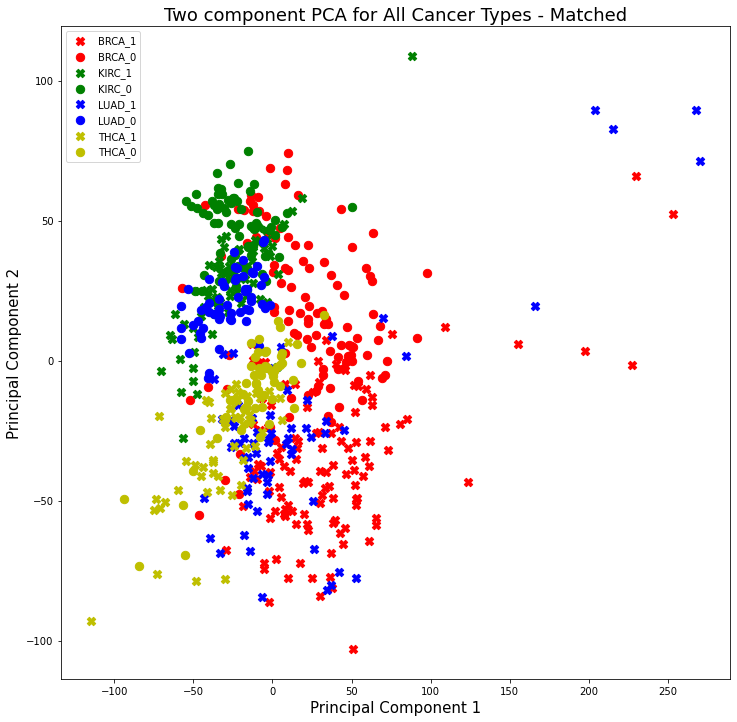

In [6]:
#Now create plot demonstrating the variance in PC 1 and PC 2 between cancer and tissue types when matched

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Two component PCA for All Cancer Types - Matched', fontsize = 18)
targets = list(final_pca_df_matched[('Cancer_tissue_status', 'Cancer_tissue_status')].unique())
colours = ['r','r','g','g','b','b','y','y']

for index, target in enumerate(targets):
    
    if '_1' in target:
    
        indicesToKeep = final_pca_df_matched[('Cancer_tissue_status', 'Cancer_tissue_status')] == target
        ax.scatter(final_pca_df_matched.loc[indicesToKeep, 'PC 1'],
                   final_pca_df_matched.loc[indicesToKeep, 'PC 2'],
                   s = 70,
                  marker = 'X',
                  c = colours[index])
    
    else:
    
        indicesToKeep = final_pca_df_matched[('Cancer_tissue_status', 'Cancer_tissue_status')] == target
        ax.scatter(final_pca_df_matched.loc[indicesToKeep, 'PC 1'],
                   final_pca_df_matched.loc[indicesToKeep, 'PC 2'],
                   s = 70,
                   c = colours[index])
        
ax.legend(targets)

In [7]:
#Now look at PCA for cis filtered genes
#First drop duplicates and then try pancan cis


In [8]:
#Check no duplicates in cancer types individually first

display(sum(BRCA_cis_95.duplicated()))
display(sum(KIRC_cis_95.duplicated()))
display(sum(LUAD_cis_95.duplicated()))
display(sum(THCA_cis_95.duplicated()))

0

0

0

0

In [6]:
#Concat all the different cis_95 switch data into one dataframe

all_cis_95 = pd.concat([BRCA_cis_95,KIRC_cis_95,LUAD_cis_95,THCA_cis_95]).reset_index(drop=True)

all_cis_95.drop('Unnamed: 0',axis=1,inplace=True)

In [7]:
#Drop any duplicated genes in the ensembl_gene_id column

all_cis_unique = all_cis_95.drop_duplicates('ensembl_gene_id')

In [8]:
all_cis_unique['Gene_symbol'].nunique()

1028

In [9]:
#Now filter the genes / columns in X_matched in relation to the cis_95_unique genes

X_cis_unique = X_matched.loc(axis=1)[:, list(all_cis_unique['ensembl_gene_id'])]

In [10]:
#Now try a PCA on the isform filtered, matched data to see if increases the variance between the dif cancer types

X_pca_cis_unique = StandardScaler().fit_transform(X_cis_unique.values)

X_pca_df_cis_unique = pd.DataFrame(X_pca_cis_unique, index=X_cis_unique.index, columns=X_cis_unique.columns)

pca_cis_unique = PCA(n_components=2)

principal_comp_cis_unique = pca_cis_unique.fit_transform(X_pca_df_cis_unique)

pca_df_cis_unique = pd.DataFrame(data = principal_comp_cis_unique, columns = ['PC 1', 'PC 2'],index=X_cis_unique.index)

final_pca_df_cis_unique = pd.concat([pca_df_cis_unique, y_matched], axis = 1)
final_pca_df_cis_unique

,PC 1,PC 2,"(Cancer_tissue_status, Cancer_tissue_status)"
TCGA-BH-A1FN,8.504584,14.741394,BRCA_1
TCGA-E9-A1NG,-0.781683,7.916629,BRCA_1
TCGA-AC-A23H,4.890041,12.380659,BRCA_1
TCGA-A7-A0DC,60.466422,-8.772879,BRCA_1
TCGA-BH-A0BA,11.462367,8.060081,BRCA_1
...,...,...,...
TCGA-EL-A3T6,-2.561035,-11.818165,THCA_0
TCGA-EM-A1CT,1.843000,-13.690180,THCA_0
TCGA-EM-A1CU,12.366538,-18.273724,THCA_0
TCGA-BJ-A2N9,-5.091212,-7.919524,THCA_0


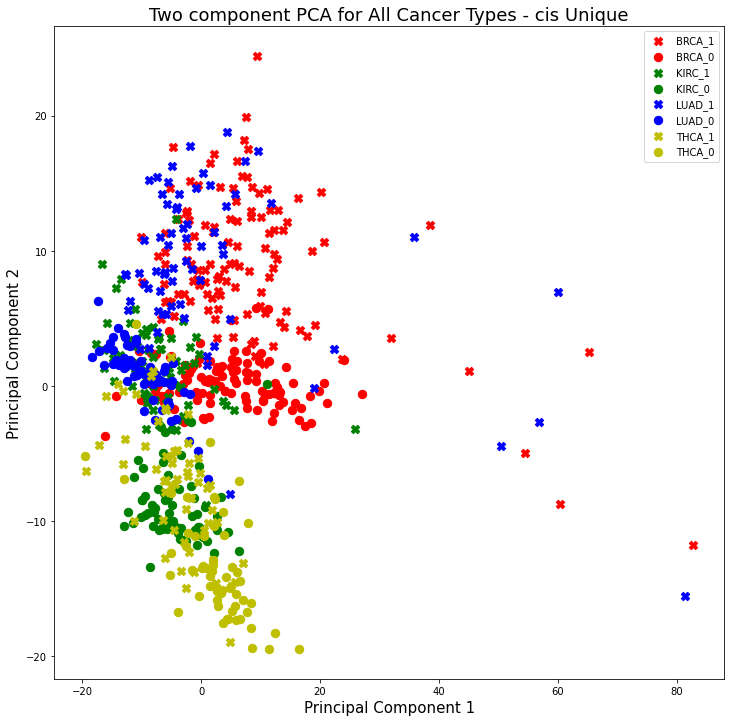

In [14]:
#Now create plot demonstrating the variance in PC 1 and PC 2 between cancer and tissue types when matched

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Two component PCA for All Cancer Types - cis Unique', fontsize = 18)
targets = list(final_pca_df_cis_unique[('Cancer_tissue_status', 'Cancer_tissue_status')].unique())
colours = ['r','r','g','g','b','b','y','y']

for index, target in enumerate(targets):
    
    if '_1' in target:
    
        indicesToKeep = final_pca_df_cis_unique[('Cancer_tissue_status', 'Cancer_tissue_status')] == target
        ax.scatter(final_pca_df_cis_unique.loc[indicesToKeep, 'PC 1'],
                   final_pca_df_cis_unique.loc[indicesToKeep, 'PC 2'],
                   s = 70,
                  marker = 'X',
                  c = colours[index])
    
    else:
    
        indicesToKeep = final_pca_df_cis_unique[('Cancer_tissue_status', 'Cancer_tissue_status')] == target
        ax.scatter(final_pca_df_cis_unique.loc[indicesToKeep, 'PC 1'],
                   final_pca_df_cis_unique.loc[indicesToKeep, 'PC 2'],
                   s = 70,
                   c = colours[index])
        
ax.legend(targets)

In [15]:
#Now replicate but for pancan cis genes

In [11]:
#Create new pancan DF by keeping only the cis 95 genes that are duplicated => set keep = False

cis_pancan = all_cis_95[all_cis_95.duplicated(subset='ensembl_gene_id',keep=False)]

In [12]:
#Now drop duplicates 

cis_pancan.drop_duplicates('ensembl_gene_id',inplace=True)

/Users/jake/opt/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [13]:
cis_pancan['ensembl_gene_id'].nunique()

456

In [14]:
#Save the pancan cis 95file to a csv

cis_pancan.to_csv('pancan_cis95.csv',sep='\t')

In [20]:
#Now filter the genes / columns in X_matched in relation to the cis_95_unique genes

X_cis_pancan = X_matched.loc(axis=1)[:, list(cis_pancan['ensembl_gene_id'])]

In [21]:
X_cis_pancan

Gene_symbol,ZNF117,BTN3A2,TYW1,C2orf74,ZNF781,ZSCAN23,NUDT2,GYPE,WFDC3,MANBA,...,RAB2A,CLEC18A,NDUFAF1,CARF,LRRC4,DIP2B,IMMT,MFSD4B,KRR1,HSPB7
Gene_ensembl_id,ENSG00000152926,ENSG00000186470,ENSG00000198874,ENSG00000237651,ENSG00000196381,ENSG00000187987,ENSG00000164978,ENSG00000197465,ENSG00000124116,ENSG00000109323,...,ENSG00000104388,ENSG00000157322,ENSG00000137806,ENSG00000138380,ENSG00000128594,ENSG00000066084,ENSG00000132305,ENSG00000173214,ENSG00000111615,ENSG00000173641
TCGA-BH-A1FN,7.120216,4.985915,7.126943,0.460833,0.479443,0.233240,8.484795,0.089906,0.636779,8.392460,...,22.206692,0.003668,4.265220,0.871021,0.937460,7.505674,24.888769,1.606509,3.930607,0.967670
TCGA-E9-A1NG,1.433767,8.839503,5.993562,1.198498,0.560200,0.112217,10.685053,0.190402,0.519732,8.067247,...,39.090631,0.015000,11.069878,0.674935,1.923410,8.383874,23.974506,0.666926,2.658659,1.167679
TCGA-AC-A23H,1.527223,1.443108,5.757805,0.447189,0.074923,0.053655,16.385836,0.094659,0.191557,11.752712,...,37.035552,0.022068,9.363763,0.541303,7.194568,10.888510,40.047793,1.837573,4.062805,0.602985
TCGA-A7-A0DC,3.617470,3.622190,9.517127,1.490931,0.594022,0.855826,17.065616,1.072144,1.649315,6.836674,...,28.169459,0.044863,5.663058,5.939136,7.835143,18.844224,19.377464,10.698406,7.939069,2.536191
TCGA-BH-A0BA,5.287703,8.654868,9.662392,1.885023,0.235394,0.464655,19.354985,0.079661,0.177011,9.000372,...,45.355053,0.017333,11.802174,1.367933,0.571341,13.531581,20.621585,1.560034,7.414326,2.685643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-EL-A3T6,1.516223,6.772177,6.123930,2.522270,0.821696,0.387982,3.173786,0.166467,0.365693,2.965511,...,31.177466,0.014818,12.715438,2.026268,0.232940,3.411491,17.103802,1.056212,3.495722,6.631671
TCGA-EM-A1CT,1.502343,3.759021,4.870024,3.618258,1.256395,0.428242,2.734556,0.120469,0.389721,6.194192,...,38.491918,0.002313,10.972208,1.817082,0.119633,3.358066,22.391998,1.067831,4.569907,3.624755
TCGA-EM-A1CU,1.956759,4.554557,5.858064,3.284223,2.377921,0.501432,2.340041,0.267666,0.169200,7.787139,...,39.790367,0.003012,8.772991,3.084203,0.077910,4.743325,18.492008,1.154876,5.391199,0.676476


In [22]:
#Now perform PCA on cis pancan

X_pca_cis_pancan = StandardScaler().fit_transform(X_cis_pancan.values)

X_pca_df_cis_pancan = pd.DataFrame(X_pca_cis_pancan, index=X_cis_pancan.index, columns=X_cis_pancan.columns)

pca_cis_pancan = PCA(n_components=2)

principal_comp_cis_pancan = pca_cis_pancan.fit_transform(X_pca_df_cis_pancan)

pca_df_cis_pancan = pd.DataFrame(data = principal_comp_cis_pancan, columns = ['PC 1', 'PC 2'],index=X_cis_pancan.index)

final_pca_df_cis_pancan = pd.concat([pca_df_cis_pancan, y_matched], axis = 1)
final_pca_df_cis_pancan

,PC 1,PC 2,"(Cancer_tissue_status, Cancer_tissue_status)"
TCGA-BH-A1FN,6.963614,11.208678,BRCA_1
TCGA-E9-A1NG,-1.453224,4.896416,BRCA_1
TCGA-AC-A23H,1.141358,7.455775,BRCA_1
TCGA-A7-A0DC,42.983927,-5.777467,BRCA_1
TCGA-BH-A0BA,6.919961,5.762261,BRCA_1
...,...,...,...
TCGA-EL-A3T6,-0.732766,-5.873460,THCA_0
TCGA-EM-A1CT,2.535792,-6.949699,THCA_0
TCGA-EM-A1CU,9.970519,-10.097956,THCA_0
TCGA-BJ-A2N9,-2.547210,-3.295896,THCA_0


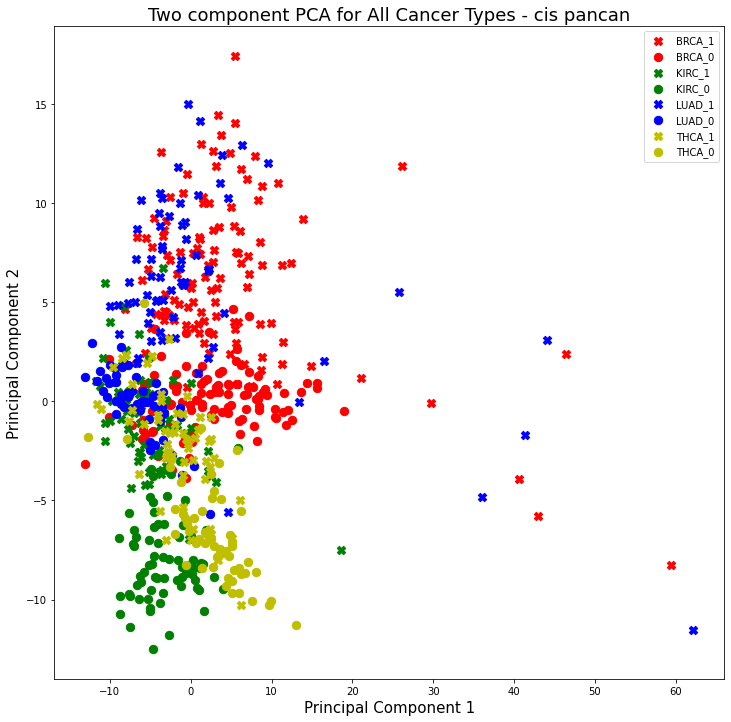

In [23]:
#Now create plot demonstrating the variance in PC 1 and PC 2 between cancer and tissue types 

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Two component PCA for All Cancer Types - cis pancan', fontsize = 18)
targets = list(final_pca_df_cis_pancan[('Cancer_tissue_status', 'Cancer_tissue_status')].unique())
colours = ['r','r','g','g','b','b','y','y']

for index, target in enumerate(targets):
    
    if '_1' in target:
    
        indicesToKeep = final_pca_df_cis_pancan[('Cancer_tissue_status', 'Cancer_tissue_status')] == target
        ax.scatter(final_pca_df_cis_pancan.loc[indicesToKeep, 'PC 1'],
                   final_pca_df_cis_pancan.loc[indicesToKeep, 'PC 2'],
                   s = 70,
                  marker = 'X',
                  c = colours[index])
    
    else:
    
        indicesToKeep = final_pca_df_cis_pancan[('Cancer_tissue_status', 'Cancer_tissue_status')] == target
        ax.scatter(final_pca_df_cis_pancan.loc[indicesToKeep, 'PC 1'],
                   final_pca_df_cis_pancan.loc[indicesToKeep, 'PC 2'],
                   s = 70,
                   c = colours[index])
        
ax.legend(targets)

In [24]:
#Now try Random Forest model on the matched data followed by the cis_95 filtered matched data

In [15]:
#First do label encoding of the target y column

#Make copy of all_cancer

all_cancers_encoded = all_cancers.copy()

le = LabelEncoder()

all_cancers_encoded['Cancer_tissue_status','Cancer_tissue_status'] = le.fit_transform(all_cancers_encoded['Cancer_tissue_status','Cancer_tissue_status'])
all_cancers_encoded

X_encoded = all_cancers_encoded.drop('Cancer_tissue_status',axis=1,level=0)
X_encoded_cis_unique = X_encoded.loc(axis=1)[:, list(all_cis_unique['ensembl_gene_id'])]
X_encoded_cis_pancan = X_encoded.loc(axis=1)[:, list(cis_pancan['ensembl_gene_id'])]

y_encoded = all_cancers_encoded['Cancer_tissue_status','Cancer_tissue_status']

In [16]:
#Create dictionary to see lables created for label encoding

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'BRCA_0': 0,
 'BRCA_1': 1,
 'KIRC_0': 2,
 'KIRC_1': 3,
 'LUAD_0': 4,
 'LUAD_1': 5,
 'THCA_0': 6,
 'THCA_1': 7}

In [17]:

#Do a train test split to keep out 30% of data for an unseen test set for both matched and unique and pancan cis eQTLs

#Now do train test splits -- change random state for full test split each time

X_develop_full, X_test_full, y_develop_full, y_test_full = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=10,stratify=y_encoded)

X_develop_cis_unique, X_test_cis_unique, y_develop_cis_unique, y_test_cis_unique = train_test_split(X_encoded_cis_unique, y_encoded, test_size=0.3, random_state=1,stratify=y_encoded)
X_develop_cis_pancan, X_test_cis_pancan, y_develop_cis_pancan, y_test_cis_pancan = train_test_split(X_encoded_cis_pancan, y_encoded, test_size=0.3, random_state=1,stratify=y_encoded)

In [28]:
#Also take a random sample of genes .. same num as unique and pancan

X_random_unique_1 = X_encoded.sample(n=len(X_encoded_cis_unique.columns),axis=1)
X_random_unique_2 = X_encoded.sample(n=len(X_encoded_cis_unique.columns),axis=1)
X_random_unique_3 = X_encoded.sample(n=len(X_encoded_cis_unique.columns),axis=1)

X_develop_cis_unique_ran_1, X_test_cis_unique_ran_1, y_develop_cis_unique_ran_1, y_test_cis_unique_ran_1 = train_test_split(X_random_unique_1, y_encoded, test_size=0.3, random_state=10,stratify=y_encoded)
X_develop_cis_unique_ran_2, X_test_cis_unique_ran_2, y_develop_cis_unique_ran_2, y_test_cis_unique_ran_2 = train_test_split(X_random_unique_2, y_encoded, test_size=0.3, random_state=24,stratify=y_encoded)
X_develop_cis_unique_ran_3, X_test_cis_unique_ran_3, y_develop_cis_unique_ran_3, y_test_cis_unique_ran_3 = train_test_split(X_random_unique_3, y_encoded, test_size=0.3, random_state=35,stratify=y_encoded)



In [29]:
#Pancan random

X_random_pancan_1 = X_encoded.sample(n=len(X_encoded_cis_pancan.columns),axis=1)
X_random_pancan_2 = X_encoded.sample(n=len(X_encoded_cis_pancan.columns),axis=1)
X_random_pancan_3 = X_encoded.sample(n=len(X_encoded_cis_pancan.columns),axis=1)

X_develop_cis_pancan_ran_1, X_test_cis_pancan_ran_1, y_develop_cis_pancan_ran_1, y_test_cis_pancan_ran_1 = train_test_split(X_random_pancan_1, y_encoded, test_size=0.3, random_state=11,stratify=y_encoded)
X_develop_cis_pancan_ran_2, X_test_cis_pancan_ran_2, y_develop_cis_pancan_ran_2, y_test_cis_pancan_ran_2 = train_test_split(X_random_pancan_2, y_encoded, test_size=0.3, random_state=29,stratify=y_encoded)
X_develop_cis_pancan_ran_3, X_test_cis_pancan_ran_3, y_develop_cis_pancan_ran_3, y_test_cis_pancan_ran_3 = train_test_split(X_random_pancan_1, y_encoded, test_size=0.3, random_state=47,stratify=y_encoded)




In [18]:
#First do simple Random Forest with gridsearch to determine optimal parameters

def grid_search_RF(X,y):
    '''Perform Random Forest grid search. Supply development X and y data.'''

    #Random Forest
    classifier = RandomForestClassifier()
    
    #Want to add PCA to pipeline .. use n_components = 10
    pca = PCA(n_components=10)

    #Pipeline containing Log Reg classifier and Log Reg with deafault settings for feature engineering
    #Also added scaler as error related to iterations / convergance appears, which can be due to 'poor scaling'
    RF_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                                  ('pca',pca),
                                  ('feature_selection', SelectFromModel(RandomForestClassifier())),
                                  ('classifier',classifier)])


    
    #The PCA searches from 1 upto max number of features / genes in 5 steps (since can't search PC's more than max num of features)
    param_grid = {
                'classifier__n_estimators': [50,100,200,300,500],
                #'classifier__max_features': ['auto', 'sqrt', 'log2'],
                #'classifier__criterion' :['gini', 'entropy'],
    }


    #Use repeated stratified k fold to maintian ratio between tumor and normal and do multliple splits of data
    r_stratkfold = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=0)

    #scoring =  roc_auc_ovr since multitarget and ovr accounts for any class imbalance
    grid_search = GridSearchCV(RF_pipeline, param_grid=param_grid, scoring="roc_auc_ovr",cv=r_stratkfold)

    #Fit on development data
    grid_search.fit(X, y)
    
    #Create dictinoary to store the best parameters
    best_params = {}
    
    for k,v in grid_search.best_params_.items():
        
        best_params[k] = v
 
    #Return the best_params dictinoary => run this fuction and save as new variable in relation to what X and y run
    return best_params

In [31]:
#Run the gridsearch for all matched, cis unique and cis pancan

In [32]:
best_params_cis_unique = grid_search_RF(X_develop_cis_unique,y_develop_cis_unique)
best_params_cis_unique

{'classifier__n_estimators': 500}

In [33]:
best_params_cis_unique_ran_1 = grid_search_RF(X_develop_cis_unique_ran_1,y_develop_cis_unique_ran_1)
best_params_cis_unique_ran_2 = grid_search_RF(X_develop_cis_unique_ran_2,y_develop_cis_unique_ran_2)
best_params_cis_unique_ran_3 = grid_search_RF(X_develop_cis_unique_ran_3,y_develop_cis_unique_ran_3)

In [34]:
best_params_cis_pancan = grid_search_RF(X_develop_cis_pancan,y_develop_cis_pancan)
best_params_cis_pancan

{'classifier__n_estimators': 100}

In [35]:
best_params_cis_pancan_ran_1 = grid_search_RF(X_develop_cis_pancan_ran_1,y_develop_cis_pancan_ran_1)
best_params_cis_pancan_ran_2 = grid_search_RF(X_develop_cis_pancan_ran_2,y_develop_cis_pancan_ran_2)
best_params_cis_pancan_ran_3 = grid_search_RF(X_develop_cis_pancan_ran_3,y_develop_cis_pancan_ran_3)

In [19]:
best_params_full = grid_search_RF(X_develop_full,y_develop_full)
best_params_full

{'classifier__n_estimators': 500}

In [37]:
# Create a function that cross validates the data

def RF_model_cv(X, y, best_params_dict, repeats = 3, splits = 3):
    '''RF model function. Takes in X and y development data, repeats, splits and the required best_params dictinoary'''

    #First perform RepeatedStratifiedKFold
    r_stratkfold = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats)
    
    # Create classifier with RF model using best_params_iso from gridsearch
    
    classifier = RandomForestClassifier(n_estimators=best_params_dict['classifier__n_estimators'],
                                   #max_features = best_params_dict['classifier__max_features'],
                                   #criterion = best_params_dict['classifier__criterion'], 
                                   random_state=1)
    
    #Create pipleine with scaling, feature selection (set as classifier to add best parameters) and the classifier
    RF_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                                  ('pca',PCA(n_components=10)),
                                   ('feature_selection', SelectFromModel(classifier)),
                                   ('classifier',classifier)])
    
    
    # evaluate the cross_validate
    scores_cv = cross_validate(RF_pipeline, X, y, cv=r_stratkfold,
                            scoring=('f1_weighted','roc_auc_ovr','balanced_accuracy','precision_weighted','recall_weighted'))
    
    #Define performance metrics to return 
    F1 = str(f"Mean F1 weighted = {scores_cv['test_f1_weighted'].mean():.3f} SEM = {sem(scores_cv['test_f1_weighted']):.3f}")
    ROCAUC = str(f"Mean ROCAUC score = {scores_cv['test_roc_auc_ovr'].mean():.3f} SEM = {sem(scores_cv['test_roc_auc_ovr']):.3f} ")
    Accuracy = str(f"Mean balanced accuracy score = {scores_cv['test_balanced_accuracy'].mean():.3f} SEM = {sem(scores_cv['test_balanced_accuracy']):.3f} ")
    Precision = str(f"Mean weighted precision = {scores_cv['test_precision_weighted'].mean():.3f} SEM = {sem(scores_cv['test_precision_weighted']):.3f} ")
    Recall = str(f"Mean weighted recall = {scores_cv['test_recall_weighted'].mean():.3f} SEM = {sem(scores_cv['test_recall_weighted']):.3f} ")
    
    return F1, ROCAUC, Accuracy,Precision,Recall

In [38]:
RF_model_cv(X_develop_cis_unique,y_develop_cis_unique,best_params_cis_unique)

('Mean F1 weighted = 0.898 SEM = 0.005',
 'Mean ROCAUC score = 0.987 SEM = 0.002 ',
 'Mean balanced accuracy score = 0.893 SEM = 0.006 ',
 'Mean weighted precision = 0.905 SEM = 0.005 ',
 'Mean weighted recall = 0.898 SEM = 0.005 ')

In [39]:
RF_model_cv(X_develop_cis_unique_ran_1,y_develop_cis_unique_ran_1,best_params_cis_unique_ran_1)

('Mean F1 weighted = 0.864 SEM = 0.012',
 'Mean ROCAUC score = 0.985 SEM = 0.003 ',
 'Mean balanced accuracy score = 0.858 SEM = 0.012 ',
 'Mean weighted precision = 0.875 SEM = 0.012 ',
 'Mean weighted recall = 0.865 SEM = 0.012 ')

In [40]:
RF_model_cv(X_develop_cis_pancan,y_develop_cis_pancan,best_params_cis_pancan)

('Mean F1 weighted = 0.852 SEM = 0.013',
 'Mean ROCAUC score = 0.983 SEM = 0.002 ',
 'Mean balanced accuracy score = 0.845 SEM = 0.012 ',
 'Mean weighted precision = 0.858 SEM = 0.012 ',
 'Mean weighted recall = 0.854 SEM = 0.012 ')

In [41]:
RF_model_cv(X_develop_cis_pancan_ran_1,y_develop_cis_pancan_ran_1,best_params_cis_pancan_ran_1)

('Mean F1 weighted = 0.879 SEM = 0.008',
 'Mean ROCAUC score = 0.989 SEM = 0.001 ',
 'Mean balanced accuracy score = 0.877 SEM = 0.009 ',
 'Mean weighted precision = 0.887 SEM = 0.008 ',
 'Mean weighted recall = 0.879 SEM = 0.008 ')

In [42]:
RF_model_cv(X_develop_full,y_develop_full,best_params_full)

('Mean F1 weighted = 0.898 SEM = 0.006',
 'Mean ROCAUC score = 0.988 SEM = 0.001 ',
 'Mean balanced accuracy score = 0.894 SEM = 0.007 ',
 'Mean weighted precision = 0.903 SEM = 0.007 ',
 'Mean weighted recall = 0.898 SEM = 0.006 ')

In [20]:
# Create function to perform test

def RF_model_test(X_develop,y_develop,X_test,y_test, best_params_dict):
    '''Function fits the predetermined RF_pipeline for the data before predicting on the unseen test data'''
    
    classifier = RandomForestClassifier(n_estimators=best_params_dict['classifier__n_estimators'],
                                   #max_features = best_params_dict['classifier__max_features'],
                                   #criterion = best_params_dict['classifier__criterion'], 
                                   random_state=1)
    
    RF_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                                  ('pca',PCA(n_components=10)),
                                   ('feature_selection', SelectFromModel(classifier)),
                                   ('classifier',classifier)])
    
    #Fit on the develop data
    RF_pipeline.fit(X_develop,y_develop)
    
    #Then make predictions on the unseen test data from the initial train test split
    predictions = RF_pipeline.predict(X_test)
    prob = RF_pipeline.predict_proba(X_test)
    
    ROCAUC =  round(roc_auc_score(y_test,prob,multi_class="ovr"),3)
    
    #Return classification report
    print (classification_report(predictions,y_test))
    
    return ROCAUC
    


In [44]:
RF_model_test(X_develop_cis_unique,y_develop_cis_unique,X_test_cis_unique,y_test_cis_unique,best_params_cis_unique)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       0.97      0.97      0.97        35
           2       1.00      0.92      0.96        24
           3       0.91      1.00      0.95        20
           4       1.00      0.94      0.97        18
           5       0.95      0.79      0.86        24
           6       0.82      0.78      0.80        18
           7       0.59      0.83      0.69        12

    accuracy                           0.92       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.93      0.92      0.92       184



0.994

In [45]:
ran_test_1_u = RF_model_test(X_develop_cis_unique_ran_1,y_develop_cis_unique_ran_1,X_test_cis_unique_ran_1,y_test_cis_unique_ran_1,best_params_cis_unique_ran_1)
ran_test_2_u = RF_model_test(X_develop_cis_unique_ran_2,y_develop_cis_unique_ran_2,X_test_cis_unique_ran_2,y_test_cis_unique_ran_2,best_params_cis_unique_ran_2)
ran_test_3_u = RF_model_test(X_develop_cis_unique_ran_3,y_develop_cis_unique_ran_3,X_test_cis_unique_ran_3,y_test_cis_unique_ran_3,best_params_cis_unique_ran_3)



              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       0.94      0.92      0.93        36
           2       1.00      0.92      0.96        24
           3       0.95      1.00      0.98        21
           4       1.00      1.00      1.00        17
           5       0.80      0.84      0.82        19
           6       0.76      0.87      0.81        15
           7       0.88      0.79      0.83        19

    accuracy                           0.92       184
   macro avg       0.91      0.92      0.91       184
weighted avg       0.93      0.92      0.92       184

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        36
           1       0.74      0.96      0.84        27
           2       0.95      0.88      0.91        24
           3       1.00      0.96      0.98        23
           4       1.00      0.89      0.94        19
           5       0.85 

In [46]:
#Calculate mean and standard error of mean for the three random gene data sets

mean_random_ROCAUC =round(np.mean([ran_test_1_u,ran_test_2_u,ran_test_3_u]),3)
STD_random_ROCAUC =round(np.std([ran_test_1_u,ran_test_2_u,ran_test_3_u]),3)

print(f'Mean random ROCAUC sore for unique = {mean_random_ROCAUC} ± {STD_random_ROCAUC}')

Mean random ROCAUC sore for unique = 0.989 ± 0.004


In [47]:
#Pancan

RF_model_test(X_develop_cis_pancan,y_develop_cis_pancan,X_test_cis_pancan,y_test_cis_pancan,best_params_cis_pancan)


              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       0.91      0.86      0.89        37
           2       0.95      0.91      0.93        23
           3       0.91      0.95      0.93        21
           4       1.00      0.94      0.97        18
           5       0.80      0.84      0.82        19
           6       0.82      0.82      0.82        17
           7       0.82      0.82      0.82        17

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



0.988

In [48]:
ran_test_1_p = RF_model_test(X_develop_cis_pancan_ran_1,y_develop_cis_pancan_ran_1,X_test_cis_pancan_ran_1,y_test_cis_pancan_ran_1,best_params_cis_pancan_ran_1)
ran_test_2_p = RF_model_test(X_develop_cis_pancan_ran_2,y_develop_cis_pancan_ran_2,X_test_cis_pancan_ran_2,y_test_cis_pancan_ran_2,best_params_cis_pancan_ran_2)
ran_test_3_p = RF_model_test(X_develop_cis_pancan_ran_3,y_develop_cis_pancan_ran_3,X_test_cis_pancan_ran_3,y_test_cis_pancan_ran_3,best_params_cis_pancan_ran_3)



              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       0.94      0.92      0.93        36
           2       0.86      1.00      0.93        19
           3       0.95      0.88      0.91        24
           4       1.00      0.81      0.89        21
           5       0.75      0.83      0.79        18
           6       0.71      0.75      0.73        16
           7       0.76      0.72      0.74        18

    accuracy                           0.88       184
   macro avg       0.87      0.86      0.86       184
weighted avg       0.89      0.88      0.88       184

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       0.97      0.89      0.93        38
           2       1.00      0.92      0.96        24
           3       0.91      0.95      0.93        21
           4       1.00      0.89      0.94        19
           5       0.85 

In [49]:

mean_random_ROCAUC =round(np.mean([ran_test_1_p,ran_test_2_p,ran_test_3_p]),3)
STD_random_ROCAUC =round(np.std([ran_test_1_p,ran_test_2_p,ran_test_3_p]),3)

print(f'Mean random ROCAUC sore for pancan = {mean_random_ROCAUC} ± {STD_random_ROCAUC}')

Mean random ROCAUC sore for pancan = 0.99 ± 0.006


In [21]:
#Full gene set

RF_model_test(X_develop_full,y_develop_full,X_test_full,y_test_full,best_params_full)

              precision    recall  f1-score   support

           0       0.97      0.94      0.96        35
           1       0.89      0.94      0.91        33
           2       1.00      0.96      0.98        23
           3       0.91      1.00      0.95        20
           4       1.00      1.00      1.00        17
           5       0.90      0.78      0.84        23
           6       0.76      0.87      0.81        15
           7       0.82      0.78      0.80        18

    accuracy                           0.91       184
   macro avg       0.91      0.91      0.91       184
weighted avg       0.92      0.91      0.91       184



0.992

In [51]:
le_name_mapping

{'BRCA_0': 0,
 'BRCA_1': 1,
 'KIRC_0': 2,
 'KIRC_1': 3,
 'LUAD_0': 4,
 'LUAD_1': 5,
 'THCA_0': 6,
 'THCA_1': 7}

In [28]:
#Def function to extract the features selected during pipeline SelectFromModel as a list 

def RF_model_features(X, y, best_params_dict, repeats = 3, splits = 3, max_features = None):
    '''RF model function. Takes in X and y development data, repeats, splits, the required best_params dictinoary and the max_features to return from SelectFromModel'''

    #First perform RepeatedStratifiedKFold
    r_stratkfold = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats)
    
    # Create classifier with LR model using best_params_cis from gridsearch
    
    classifier = RandomForestClassifier(n_estimators=best_params_dict['classifier__n_estimators'],
                                   #max_features = best_params_dict['classifier__max_features'],
                                   #criterion = best_params_dict['classifier__criterion'], 
                                   random_state=1)
    
    #Create pipleine with scaling, feature selection (set as classifier to add best parameters) and the classifier
    RF_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                                  ('pca',PCA(n_components=10)),
                                   ('feature_selection', SelectFromModel(classifier,max_features=max_features)),
                                   ('classifier',classifier)])
    
    
    # evaluate the cross_validate
    scores_cv = cross_validate(RF_pipeline, X, y, cv=r_stratkfold,
                            scoring=('f1_weighted','roc_auc_ovr','balanced_accuracy','precision_weighted','recall_weighted'))
    
    
    #To get the features selected via SelectFromModel need to fit the pipeline and extract the named_steps['feature_selection']
    selected_features = RF_pipeline.named_steps['feature_selection'].fit(X,y)
    
    feature_importances =  X.columns[(RF_pipeline.named_steps['feature_selection'].get_support())]
    
    feat_importances_RF = pd.Series(RF_pipeline.named_steps['feature_selection'].estimator_.feature_importances_,index= X.columns)

#     plt.figure(figsize=(12,6))
#     feat_importances_RF.nlargest(max_features).plot(kind='barh')

    fig = feat_importances_RF.nlargest(max_features).plot.barh(figsize=(12,8),fontsize=18,edgecolor='black')

    #fig.set_yticklabels(iso_data_ne['Cancer_types'],rotation=0,fontsize=18)
    fig.set_ylabel('Gene Hugo Symbol and Ensembl ID',fontsize=20)
    fig.set_xlabel('Feature Importance',fontsize=18)
    
    
    fig.figure.savefig('Cancer_type_cis_feature_importance_allgenes.pdf',dpi=300, bbox_inches = "tight")

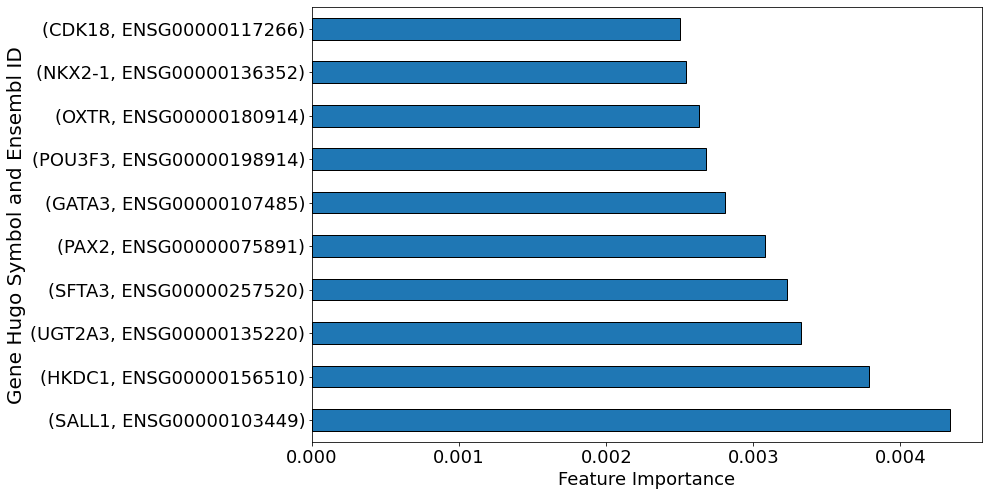

In [29]:
RF_model_features(X_develop_full,y_develop_full,best_params_full,max_features=10)


In [26]:
#Def function to extract the features selected during pipeline SelectFromModel as a list 

def RF_model_features_class(X, y, best_params_dict, repeats = 3, splits = 3, max_features = None):
    '''RF model function. Takes in X and y development data, repeats, splits, the required best_params dictinoary and the max_features to return from SelectFromModel'''

    #First perform RepeatedStratifiedKFold
    r_stratkfold = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats)
    
    # Create classifier with LR model using best_params_cis from gridsearch
    
    classifier = RandomForestClassifier(n_estimators=best_params_dict['classifier__n_estimators'],
                                   #max_features = best_params_dict['classifier__max_features'],
                                   #criterion = best_params_dict['classifier__criterion'], 
                                   random_state=1)
    
    #Create pipleine with scaling, feature selection (set as classifier to add best parameters) and the classifier
    RF_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                                  ('pca',PCA(n_components=10)),
                                   ('feature_selection', SelectFromModel(classifier,max_features=max_features)),
                                   ('classifier',classifier)])
    
    
    # evaluate the cross_validate
    #scores_cv = cross_validate(RF_pipeline, X, y, cv=r_stratkfold,
                            #scoring=('f1_weighted','roc_auc_ovr','balanced_accuracy','precision_weighted','recall_weighted'))
    
    
    #To get the features selected via SelectFromModel need to fit the pipeline and extract the named_steps['feature_selection']
    RF_pipeline.named_steps['classifier'].fit(X,y)
    
    feature_importances =  RF_pipeline.named_steps['classifier'].feature_importances_
    
    feat_importances_RF = pd.Series(feature_importances,index= X.columns)

#     plt.figure(figsize=(12,6))
#     feat_importances_RF.nlargest(max_features).plot(kind='barh')

    fig = feat_importances_RF.nlargest(max_features).plot.barh(figsize=(12,8),fontsize=18,edgecolor='black')

    #fig.set_yticklabels(iso_data_ne['Cancer_types'],rotation=0,fontsize=18)
    fig.set_ylabel('Gene Hugo Symbol and Ensembl ID',fontsize=20)
    fig.set_xlabel('Feature Importance',fontsize=18)
    
    
    #fig.figure.savefig('Cancer_type_cis_feature_importance_allgenes.pdf',dpi=300, bbox_inches = "tight")

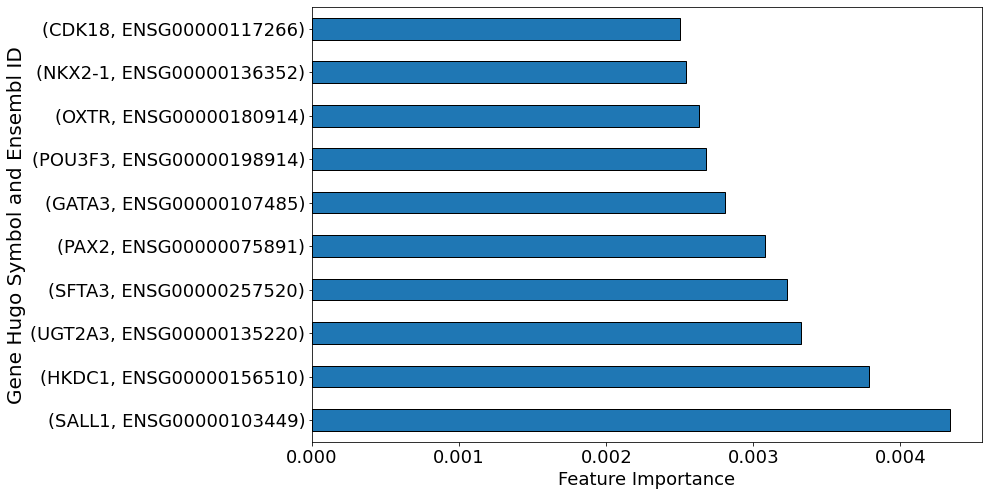

In [27]:
RF_model_features_class(X_develop_full,y_develop_full,best_params_full,max_features=10)

